# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [1]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

2024-06-07 14:12:40.085505: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 14:12:40.090230: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 14:12:40.190727: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-07 14:12:40.652446: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 14:12:44.489747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [2]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)


#### Example: to_categorical

Converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.

In [3]:
# Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
labels = np.array([0, 2, 1, 2, 0])
# `to_categorical` converts this into a matrix with as many columns as there are classes.
# The number of rows stays the same.
keras.utils.to_categorical(labels) # accende la posizione

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

#### Reshape data and convert labels to be used with categorical cross entropy

X_train shape: (60000, 784)
X_test shape: (10000, 784)



an example of a data point with label 4


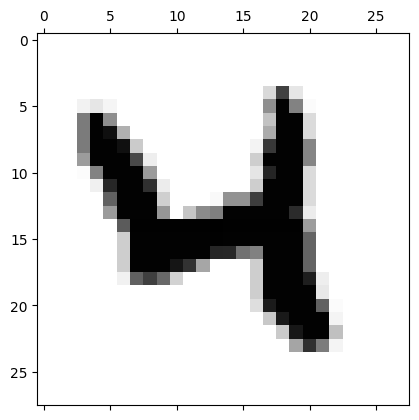

... and with label [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [4]:
# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[20])
# matshow: display a matrix in a new figure window
plt.matshow(X_train[20,:].reshape(28,28),cmap='binary')
plt.show()

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[20], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [6]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model():
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=SGD(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

In [7]:
# training parameters
batch_size = 32
epochs = 5

# create the deep neural net
model_DNN = compile_model()

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

/home/matteo/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - acc: 0.6433 - loss: 1.1709 - val_acc: 0.9124 - val_loss: 0.3178
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.8830 - loss: 0.4128 - val_acc: 0.9301 - val_loss: 0.2426
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - acc: 0.9066 - loss: 0.3276 - val_acc: 0.9416 - val_loss: 0.2003
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - acc: 0.9220 - loss: 0.2781 - val_acc: 0.9479 - val_loss: 0.1785
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - acc: 0.9317 - loss: 0.2426 - val_acc: 0.9533 - val_loss: 0.1575


#### Step 5: Evaluate the Model Performance on the *Unseen* Test Data

Next, we evaluate the model and read of the loss on the test data, and its accuracy using the `evaluate()` method.

  1/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - acc: 0.9688 - loss: 0.1029

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9461 - loss: 0.1814

Test loss: 0.15748831629753113
Test accuracy: 0.9532999992370605


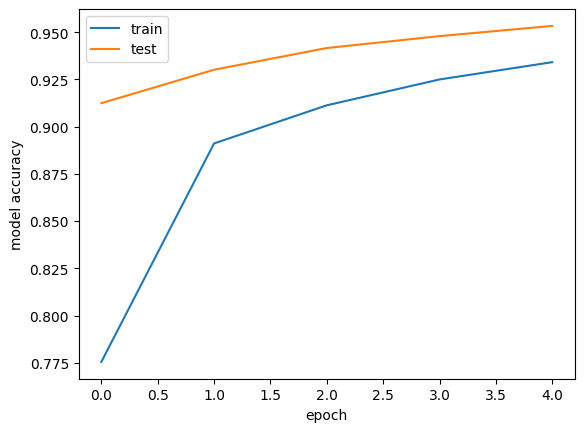

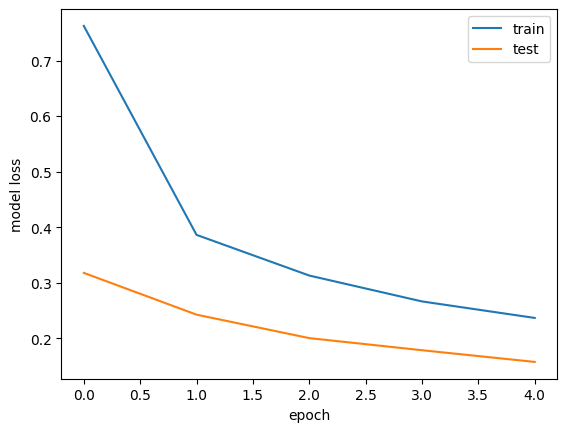

In [8]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


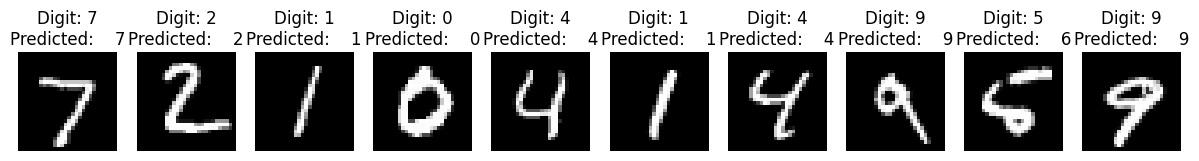

In [9]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

Per questo esercizio ho scelto la DNN formata da due layer consecutivi di 400 e 100 neuroni con attivazione relu, seguiti da un dropout del 50% e da un layer finale di 10 neuroni (pari ai possibili output) con attivazione softmax. Il training della rete è avvenuto con un 60000 dati di training e 10000 dati di validazione.

A parità dei dati di training e di validazione sono andato a confrontare le performance dei diversi ottimizzatori stocastici. In tutti i casi ho utilizzato $N_{epoch}=80$ e batch_size=32. Nei grafici riportati, a sinistra, si può osservare l'accuracy del modello (ovvero il rapporto tra il numero di dati predetti correttamente e quelli totali) sia sui dati di training sia su quelli di validazione; a destra invece, è presente il valore della loss function al variare del numero di epoche.

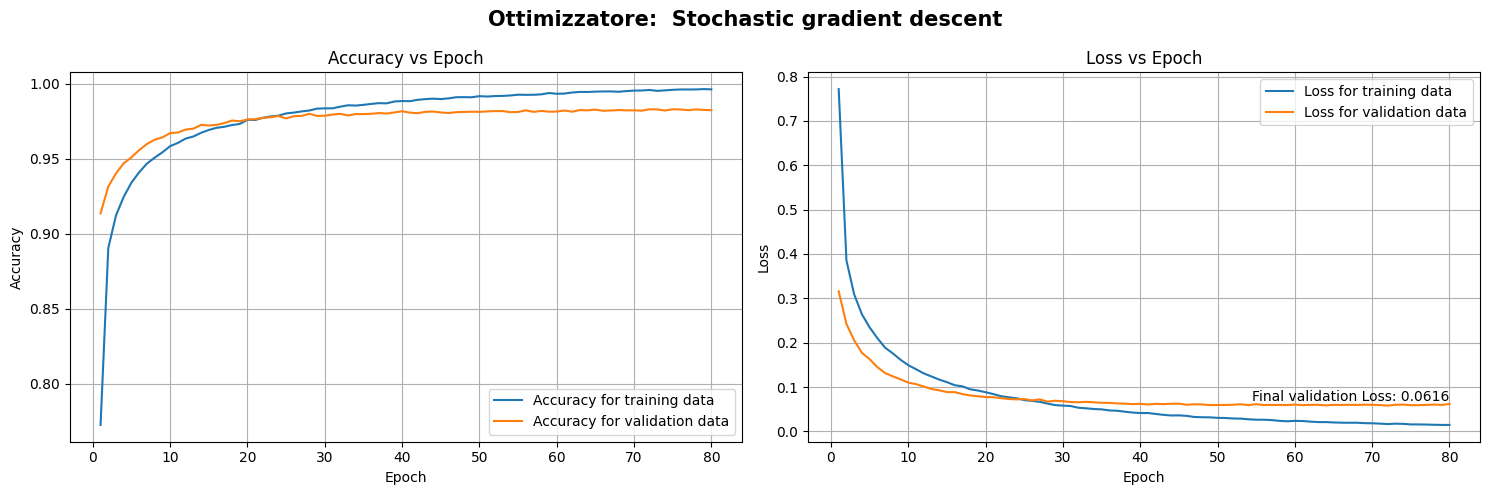

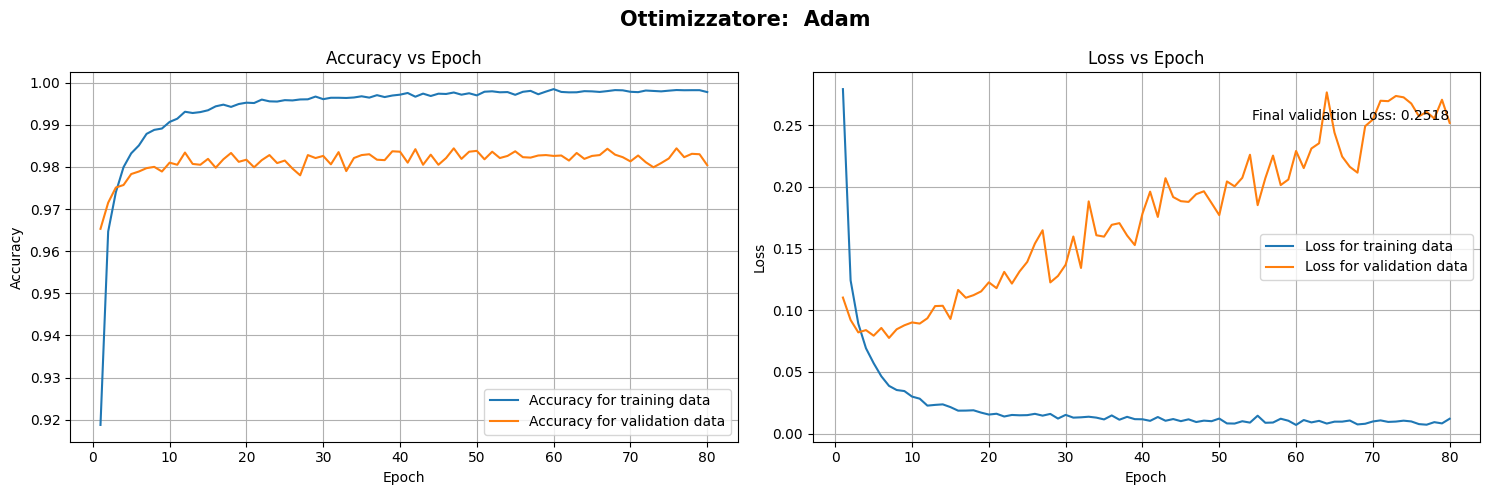

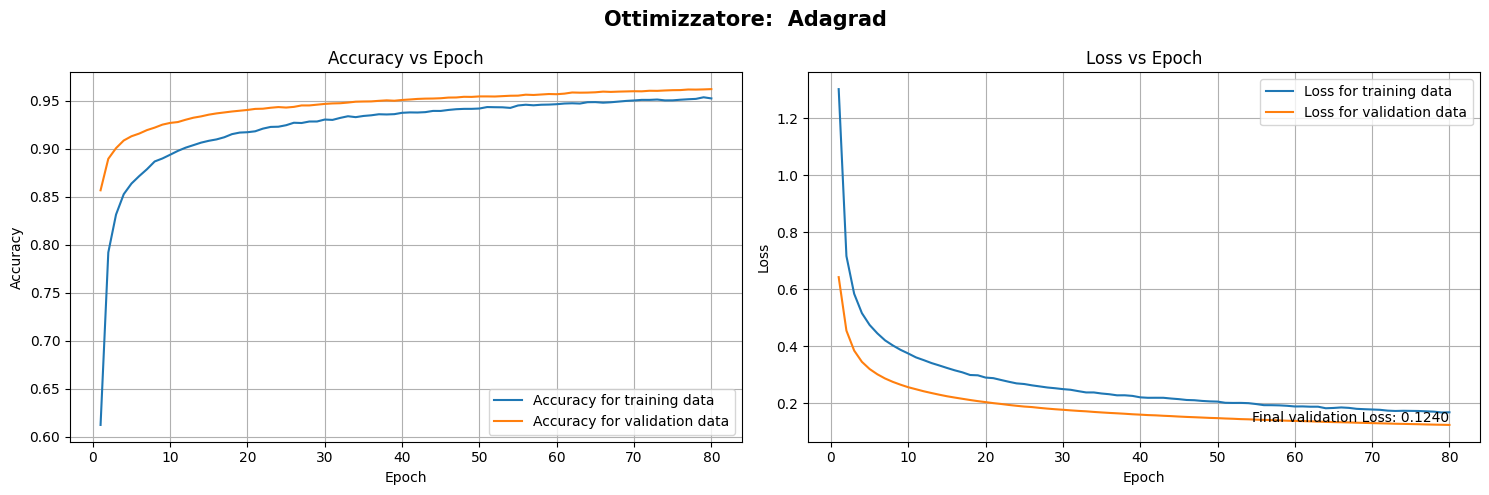

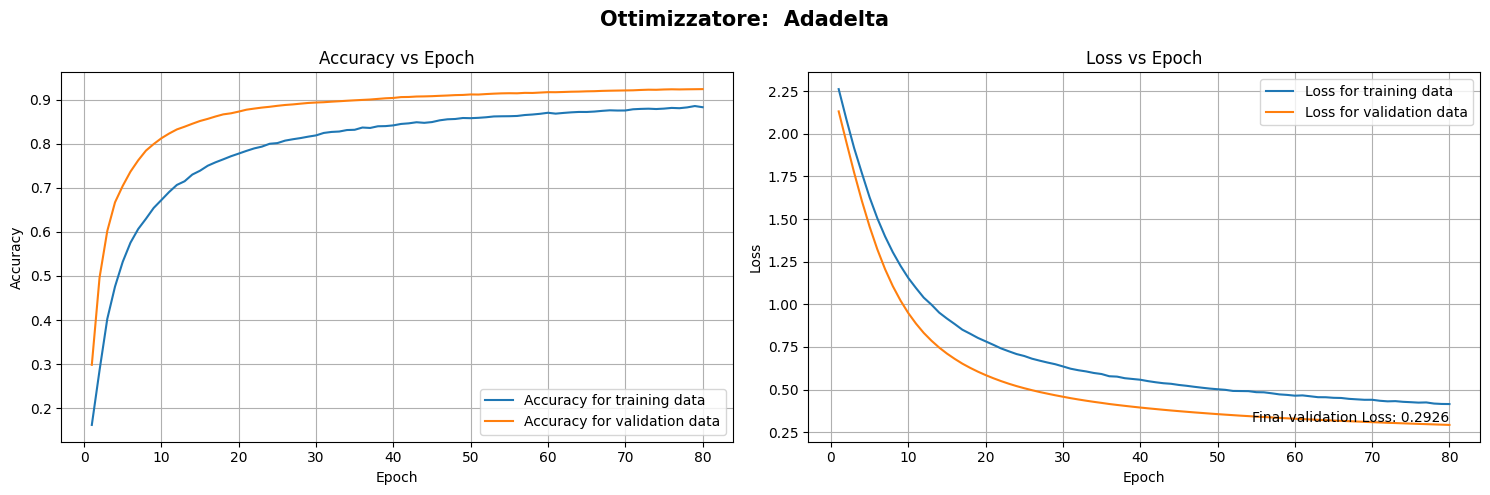

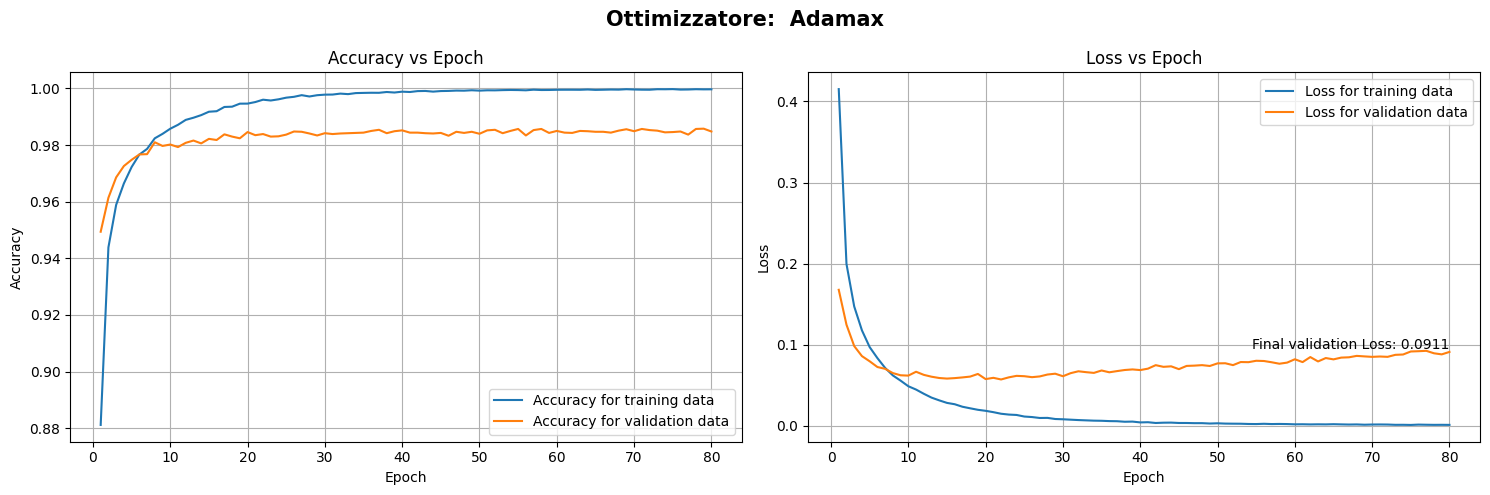

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to read data from a .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, sep='\s+', skiprows=0)
    return data

# List of filenames
filenames = ['esercizio_12.1/training_history_sgd.dat', 'esercizio_12.1/training_history_adam.dat', 'esercizio_12.1/training_history_adagrad.dat', 'esercizio_12.1/training_history_adadelta.dat', 'esercizio_12.1/training_history_adamax.dat']
titoli = ['Stochastic gradient descent', 'Adam', 'Adagrad', 'Adadelta', 'Adamax']

# Read all files
data_frames = [read_dat_file(filename) for filename in filenames]

# Plot Accuracy and Validation Accuracy vs. Epoch for all files
for i, df in enumerate(data_frames):
    plt.figure(figsize=(15, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(df['Epoch'], df['accuracy'], label='Accuracy for training data')
    plt.plot(df['Epoch'], df['Validation_accuracy'], label='Accuracy for validation data')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    #plt.ylim(0.9, 1)
    plt.title(f'Accuracy vs Epoch')
    plt.grid(True)
    plt.legend()

    # Plot Loss and Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(df['Epoch'], df['Loss'], label='Loss for training data')
    plt.plot(df['Epoch'], df['Validation_Loss'], label='Loss for validation data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.ylim(0, 0.5)
    plt.title(f'Loss vs Epoch')
    plt.grid(True)
    plt.legend()

    # Print final value of Validation Loss
    final_Validation_Loss = df['Validation_Loss'].iloc[-1]
    plt.text(df['Epoch'].iloc[-1], final_Validation_Loss, f'Final validation Loss: {final_Validation_Loss:.4f}', ha='right', va='bottom')

    # Add title above the row of plots
    plt.suptitle('Ottimizzatore:  ' + titoli[i], fontsize = 15, fontweight = "bold")

    plt.tight_layout()
    plt.show()


Dai grafici si può osservare che in alcuni casi è presente il fenomeno dell'overfitting. Questo accade quando il modello inizia a imparare anche il rumore nei dati di training, riducendo così il suo potere predittivo su dati non visti, come quelli di validazione. Il caso più evidente è quello relativo all'ottimizzatore Adam, dove questo fenomeno è ben visibile.

Analizzando le prestazioni dei singoli ottimizzatori, si nota che lo stochastic gradient descent (SGD) è uno dei migliori (vedi grafico sotto). Adamax, invece, mostra una grande precisione sui dati di training, ma meno sui dati di validazione: questo indica che la rete neurale con questo ottimizzatore impara molto velocemente, ma apprende anche le fluttuazioni dei dati di training. Al contrario, Adadelta è molto più lento nell'apprendimento; ciò è evidente poiché, dopo 80 epoche, la loss risulta essere significativamente maggiore rispetto a tutti gli altri casi.

Sotto sono presenti le prime 10 cifre non predette correttamente dal modello in base all'ottimizzatore scelto.

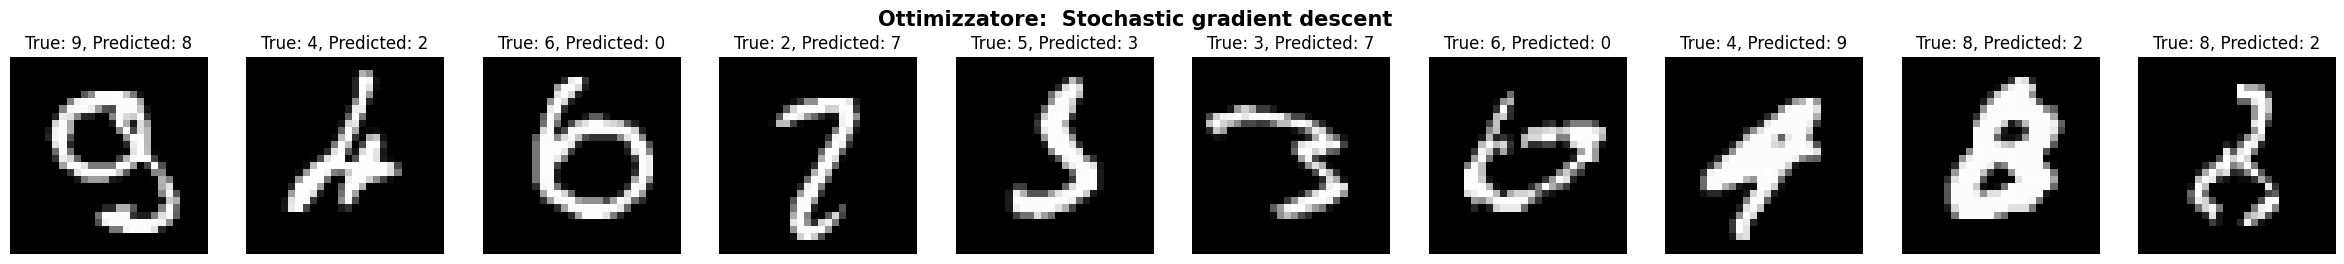

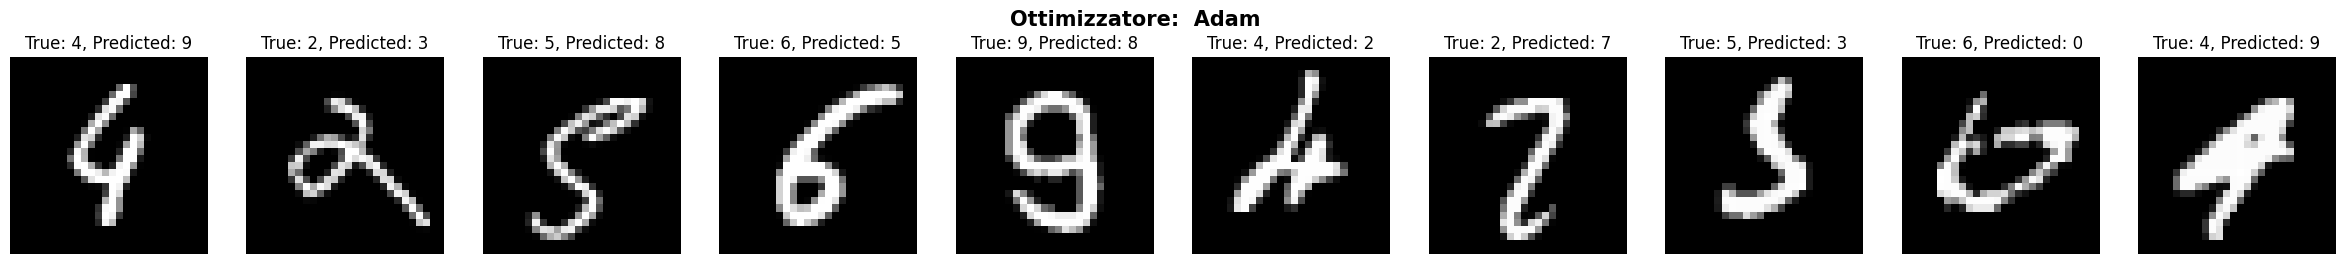

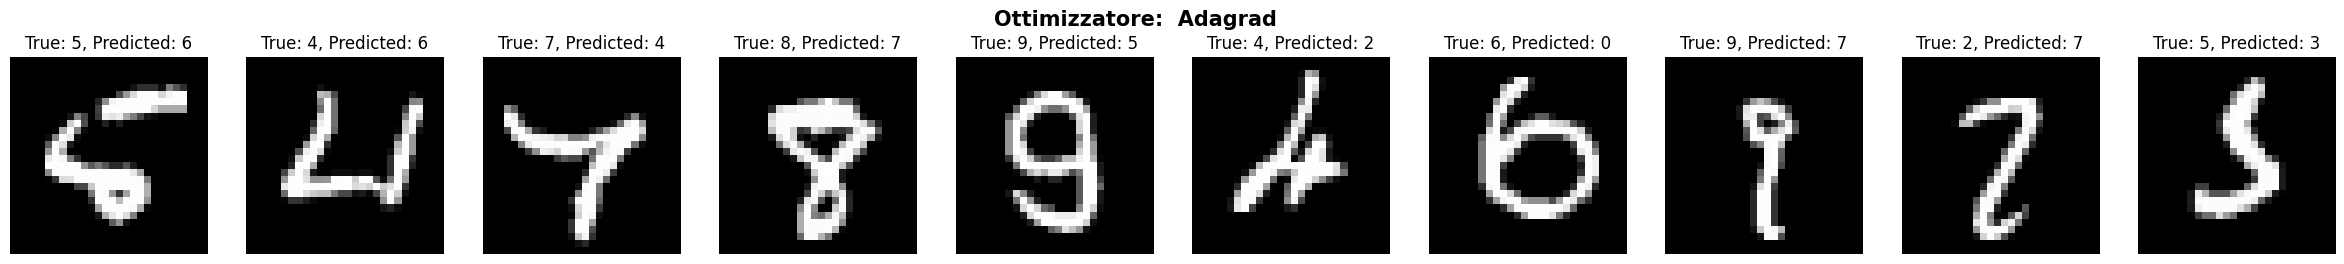

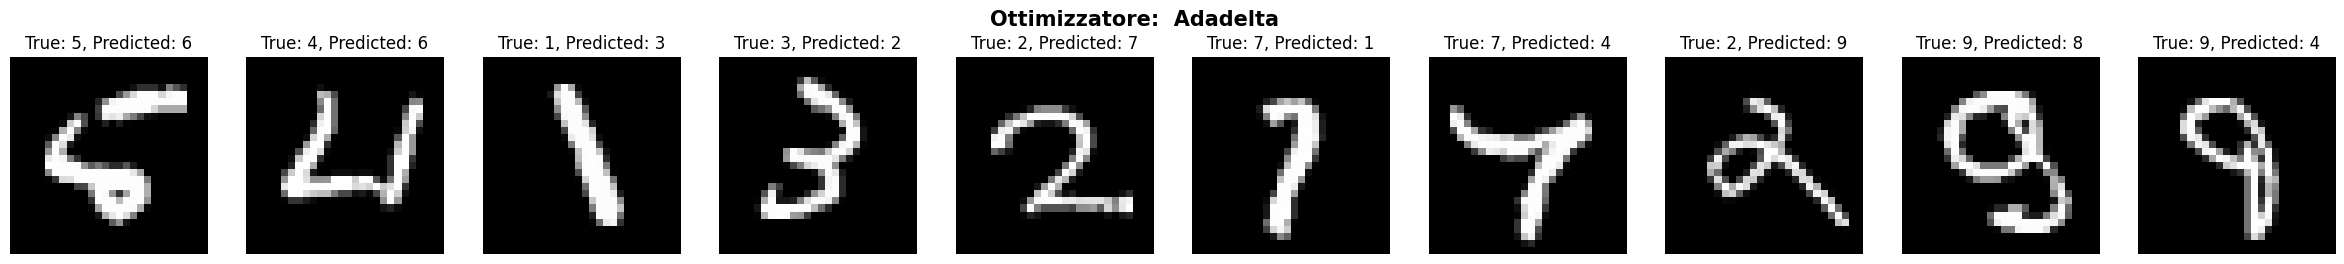

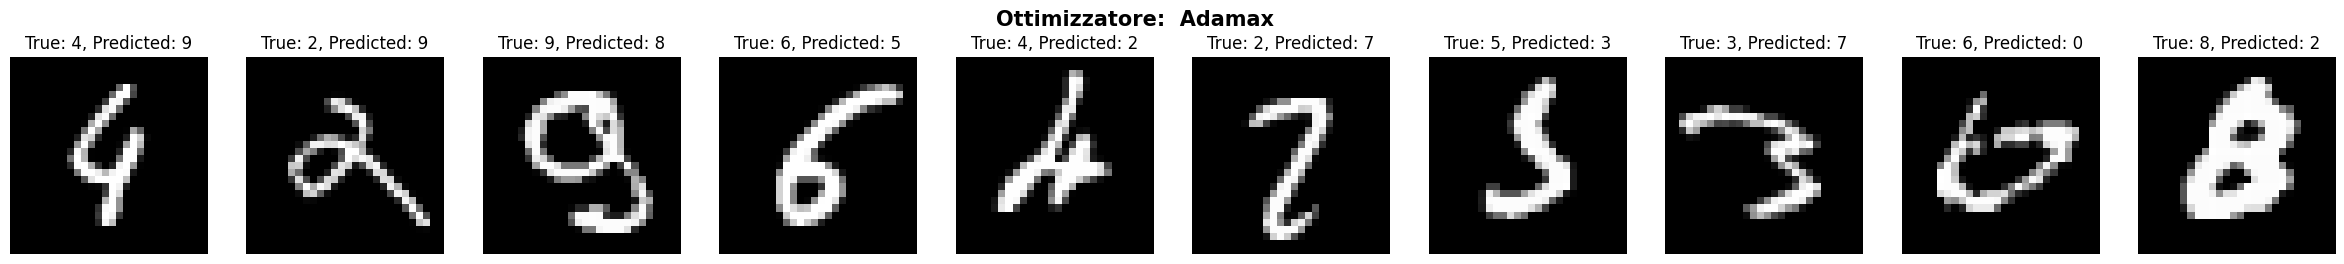

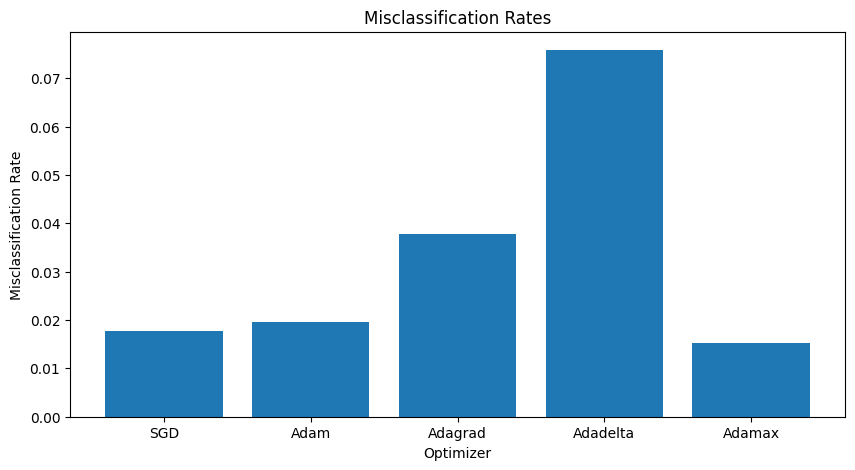

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to read data from a .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, sep='\s+', skiprows=0)
    return data

# List of filenames
filenames = ['esercizio_12.1/predizioni_sgd.dat', 'esercizio_12.1/predizioni_adam.dat', 'esercizio_12.1/predizioni_adagrad.dat', 'esercizio_12.1/predizioni_adadelta.dat', 'esercizio_12.1/predizioni_adamax.dat']
titoli = ['Stochastic gradient descent', 'Adam', 'Adagrad', 'Adadelta', 'Adamax']
# Read data from each file and calculate misclassification rate
misclassification_rates = []
j = 0
for filename in filenames:
    data = read_dat_file(filename)
    true_labels = data.iloc[:, 1].values
    predicted_labels = data.iloc[:, 2].values
    misclassified = sum(true_labels != predicted_labels)
    total = len(true_labels)
    misclassification_rate = misclassified / total
    misclassification_rates.append(misclassification_rate)

    # Get indices of misclassified digits
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]
    misclassified_indices = misclassified_indices[:10]  # Select the first 10 misclassified digits

    # Plot the misclassified digits
    plt.figure(figsize=(30, 3))
    for i, index in enumerate(misclassified_indices, 1):
        plt.subplot(1, 10, i)
        plt.imshow(X_test[index+1].reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_labels[index]}, Predicted: {predicted_labels[index]}')
        plt.axis('off')
    plt.suptitle('Ottimizzatore:  ' + titoli[j], fontsize = 15, fontweight = "bold")
    j += 1
    plt.show()

# Plot misclassification rates
plt.figure(figsize=(10, 5))
plt.bar(range(len(filenames)), misclassification_rates, tick_label=['SGD', 'Adam', 'Adagrad', 'Adadelta','Adamax'])
plt.title('Misclassification Rates')
plt.xlabel('Optimizer')
plt.ylabel('Misclassification Rate')
plt.show()



Nell'ultimo grafico si osserva il rapporto tra il numero di predizioni errate sui dati di validazione e il numero totale di dati di validazione. Questo rapporto rappresenta l'errore di validazione finale, che è calcolato come (1 - accuracy) sui dati di validazione alla fine del training. In altre parole, mostra la percentuale di dati di validazione che il modello ha classificato in modo errato dopo 80 epoche di addestramento. Nei grafici precedenti, questo punto corrisponde precisamente al punto $N_{epoch}$, permettendo così di confrontare direttamente le prestazioni dei diversi ottimizzatori al termine del processo di training.

#### Creating Convolutional Neural Nets with Keras

We have so far considered each MNIST data sample as a $(28\times 28,)$-long 1d vector. On the other hand, we do know that in every one of the hand-written digits there are *local* spatial correlations between the pixels, but also *translational invariance*, which we would like to take advantage of to improve the accuracy of our classification model. To this end, we first need to reshape the training and test input data as follows

One can ask the question of whether a neural net can learn to recognize such local patterns. This can be achieved by using convolutional layers.

### Exercise 12.2

Change the architecture of your DNN using convolutional layers. Use `Conv2D`, `MaxPooling2D`, `Dropout`, but also do not forget `Flatten`, a standard `Dense` layer and `soft-max` in the end. I have merged step 2 and 3 in the following definition of `create_CNN()` that **<span style="color:red">you should complete</span>**:

Train your DCNN and evaluate its performance proceeding exactly as before:

In the end, **<span style="color:red">add the evaluation of your CNN performances</span>** like that used for the DNN.

Utilizzo adesso una convolutional neural network, rete neurale più adatta a questo tipo di compito. Dopo averla implementata ho provato a cambiarne i parametri in modo da trovare il modello migliore possibile. La rete utilizzata ha la seguente forma (comune a tutti i modelli):

- primo layer con operazione di convoluzione e attivazione relu;
- maxpooling con filtro 2x2;
- secondo layer con operazione di convoluzione e attivazione relu;
- maxpooling con filtro 2x2;
- flatten;
- dropout;
- layer di 200 neuroni con attivazione relu;
- layer di 100 neuroni con attivazione relu;
- dropout;
- layer di 10 neuroni con attivazione softmax.

Inoltre si hanno le seguenti caratteristiche:
- funzione di loss categorical_cross_entropy;
- ottimizzatore statistico SGD;


#### Modello 1

Prima di tutto ho provato a riprodurre un modello simile a quello presente nelle slide; qui in particolare ho considerato nel primo layer 10 filtri 5x5 e nel secondo 16. Per quanto riguarda il dropout, ho fatto si che si spegnessero in tutti e due i casi il 25% dei neuroni. Di seguito il grafico con le prestazioni:

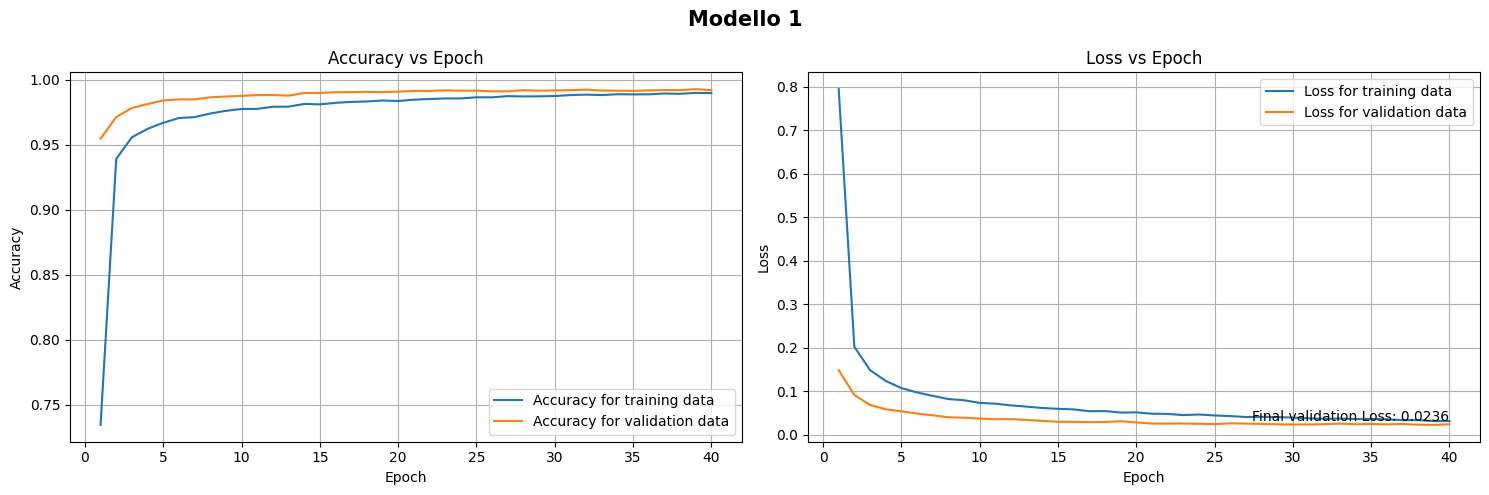

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to read data from a .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, sep='\s+', skiprows=0)
    return data

# List of filenames
filenames = ['esercizio_12.2/training_history_mod1.dat']

# Read all files
data_frames = [read_dat_file(filename) for filename in filenames]

# Create a larger figure
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
for df in data_frames:
    plt.plot(df['Epoch'], df['accuracy'], label='Accuracy for training data')
    plt.plot(df['Epoch'], df['Validation_accuracy'], label='Accuracy for validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epoch')
plt.grid(True)
plt.legend()

# Plot Loss and Validation Loss
plt.subplot(1, 2, 2)
for df in data_frames:
    plt.plot(df['Epoch'], df['Loss'], label='Loss for training data')
    plt.plot(df['Epoch'], df['Validation_Loss'], label='Loss for validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss vs Epoch')
plt.grid(True)
plt.legend()

# Print final value of Validation Loss
for df in data_frames:
    final_Validation_Loss = df['Validation_Loss'].iloc[-1]
    plt.text(df['Epoch'].iloc[-1], final_Validation_Loss, f'Final validation Loss: {final_Validation_Loss:.4f}', ha='right', va='bottom')

# Add title above the row of plots
plt.suptitle('Modello 1', fontsize = 15, fontweight = "bold")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


#### Modello 2

Successivamente ho provato ad aumentare il numero di parametri totali (e quindi la complessità), per capire come si comporta la rete con queste altre caratteristiche; in particolare ho considerato nel primo layer 30 filtri 5x5 e nel secondo 36. Anche in questo caso, per quanto riguarda il dropout, ho fatto sì che si spegnessero il 25% dei neuroni. Di seguito il grafico con le prestazioni:

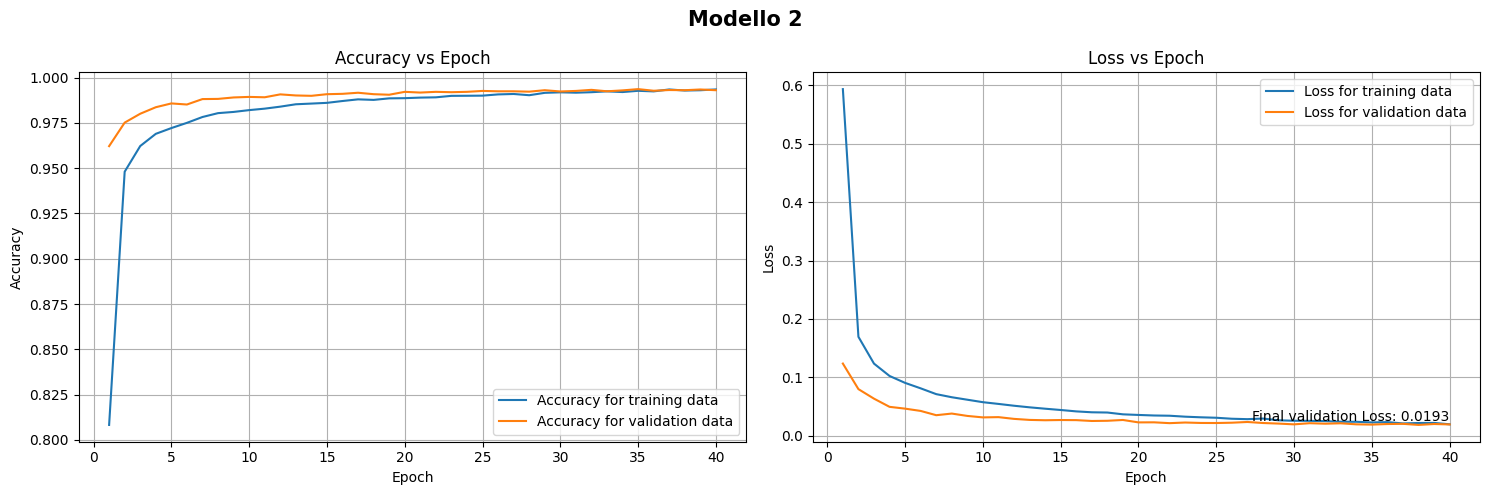

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to read data from a .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, sep='\s+', skiprows=0)
    return data

# List of filenames
filenames = ['esercizio_12.2/training_history_mod3.dat']

# Read all files
data_frames = [read_dat_file(filename) for filename in filenames]

# Create a larger figure
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
for df in data_frames:
    plt.plot(df['Epoch'], df['accuracy'], label='Accuracy for training data')
    plt.plot(df['Epoch'], df['Validation_accuracy'], label='Accuracy for validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epoch')
plt.grid(True)
plt.legend()

# Plot Loss and Validation Loss
plt.subplot(1, 2, 2)
for df in data_frames:
    plt.plot(df['Epoch'], df['Loss'], label='Loss for training data')
    plt.plot(df['Epoch'], df['Validation_Loss'], label='Loss for validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss vs Epoch')
plt.grid(True)
plt.legend()

# Print final value of Validation Loss
for df in data_frames:
    final_Validation_Loss = df['Validation_Loss'].iloc[-1]
    plt.text(df['Epoch'].iloc[-1], final_Validation_Loss, f'Final validation Loss: {final_Validation_Loss:.4f}', ha='right', va='bottom')

# Add title above the row of plots
plt.suptitle('Modello 2', fontsize = 15, fontweight = "bold")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


#### Modello 3

Al contrario ho provato a diminuire il numero di parametri totali (e quindi la complessità), per capire come si comporta la rete con queste altre caratteristiche; in particolare ho considerato nel primo layer 2 filtri 5x5 e nel secondo 5 uguali. Anche in questo caso, per quanto riguarda il dropout, ho fatto sì che si spegnessero il 25% dei neuroni. Di seguito il grafico con le prestazioni:

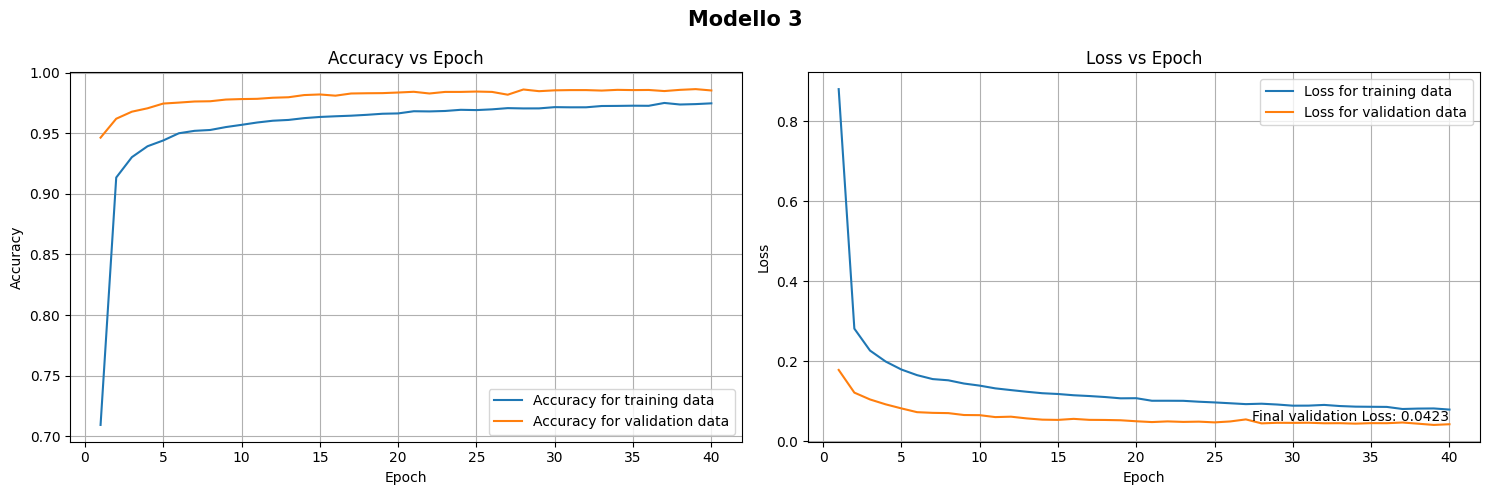

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to read data from a .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, sep='\s+', skiprows=0)
    return data

# List of filenames
filenames = ['esercizio_12.2/training_history_mod4.dat']

# Read all files
data_frames = [read_dat_file(filename) for filename in filenames]

# Create a larger figure
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
for df in data_frames:
    plt.plot(df['Epoch'], df['accuracy'], label='Accuracy for training data')
    plt.plot(df['Epoch'], df['Validation_accuracy'], label='Accuracy for validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epoch')
plt.grid(True)
plt.legend()

# Plot Loss and Validation Loss
plt.subplot(1, 2, 2)
for df in data_frames:
    plt.plot(df['Epoch'], df['Loss'], label='Loss for training data')
    plt.plot(df['Epoch'], df['Validation_Loss'], label='Loss for validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss vs Epoch')
plt.grid(True)
plt.legend()

# Print final value of Validation Loss
for df in data_frames:
    final_Validation_Loss = df['Validation_Loss'].iloc[-1]
    plt.text(df['Epoch'].iloc[-1], final_Validation_Loss, f'Final validation Loss: {final_Validation_Loss:.4f}', ha='right', va='bottom')

# Add title above the row of plots
plt.suptitle('Modello 3', fontsize = 15, fontweight = "bold")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


#### Modello 4

Infine, per comprendere l'effetto dei layer di dropout all'interno della rete neurale, ho condotto un esperimento rimuovendoli e confrontando le prestazioni con il Modello 1. Ho mantenuto le caratteristiche strutturali del Modello 1 e ho rimosso la disattivazione casuale di alcuni neuroni durante l'addestramento.

Il risultato è stato un miglioramento delle prestazioni sul set di dati di training, ma una riduzione delle prestazioni sul set di dati di validazione. Questo suggerisce che l'aggiunta dei layer di dropout nel Modello 1 ha giocato un ruolo cruciale nel prevenire l'overfitting.

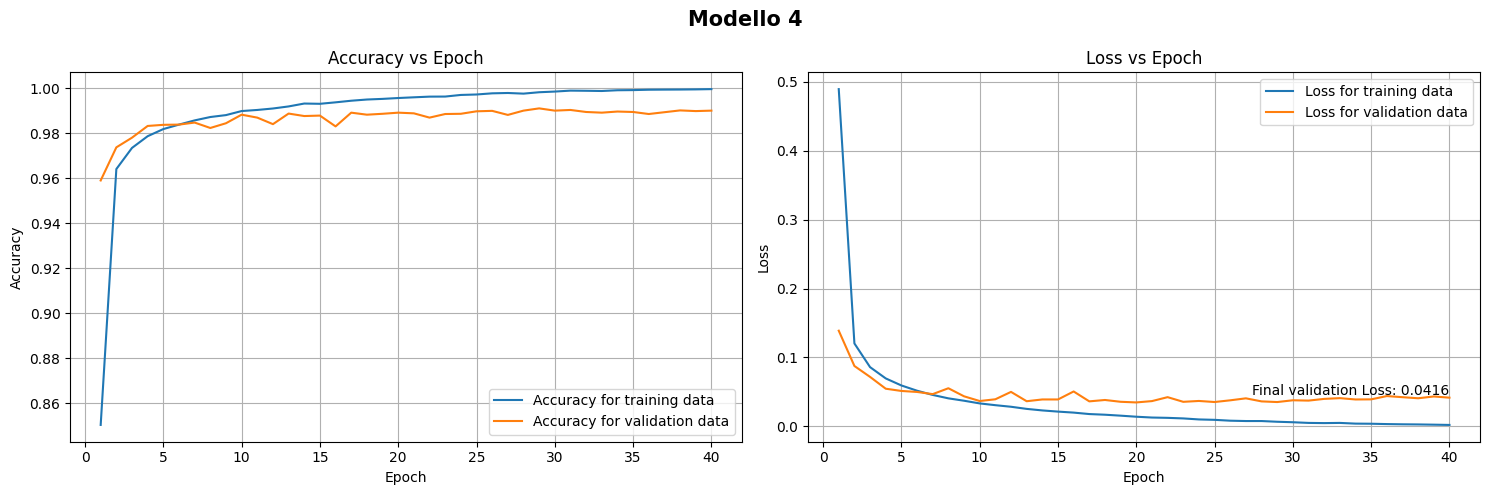

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to read data from a .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, sep='\s+', skiprows=0)
    return data

# List of filenames
filenames = ['esercizio_12.2/training_history_mod2.dat']

# Read all files
data_frames = [read_dat_file(filename) for filename in filenames]

# Create a larger figure
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
for df in data_frames:
    plt.plot(df['Epoch'], df['accuracy'], label='Accuracy for training data')
    plt.plot(df['Epoch'], df['Validation_accuracy'], label='Accuracy for validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy vs Epoch')
plt.grid(True)
plt.legend()

# Plot Loss and Validation Loss
plt.subplot(1, 2, 2)
for df in data_frames:
    plt.plot(df['Epoch'], df['Loss'], label='Loss for training data')
    plt.plot(df['Epoch'], df['Validation_Loss'], label='Loss for validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss vs Epoch')
plt.grid(True)
plt.legend()

# Print final value of Validation Loss
for df in data_frames:
    final_Validation_Loss = df['Validation_Loss'].iloc[-1]
    plt.text(df['Epoch'].iloc[-1], final_Validation_Loss, f'Final validation Loss: {final_Validation_Loss:.4f}', ha='right', va='bottom')

# Add title above the row of plots
plt.suptitle('Modello 4', fontsize = 15, fontweight = "bold")

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


Come nell'esercizio precedente, sotto sono presenti le prime dieci cifre sbagliate dai vari modelli. 

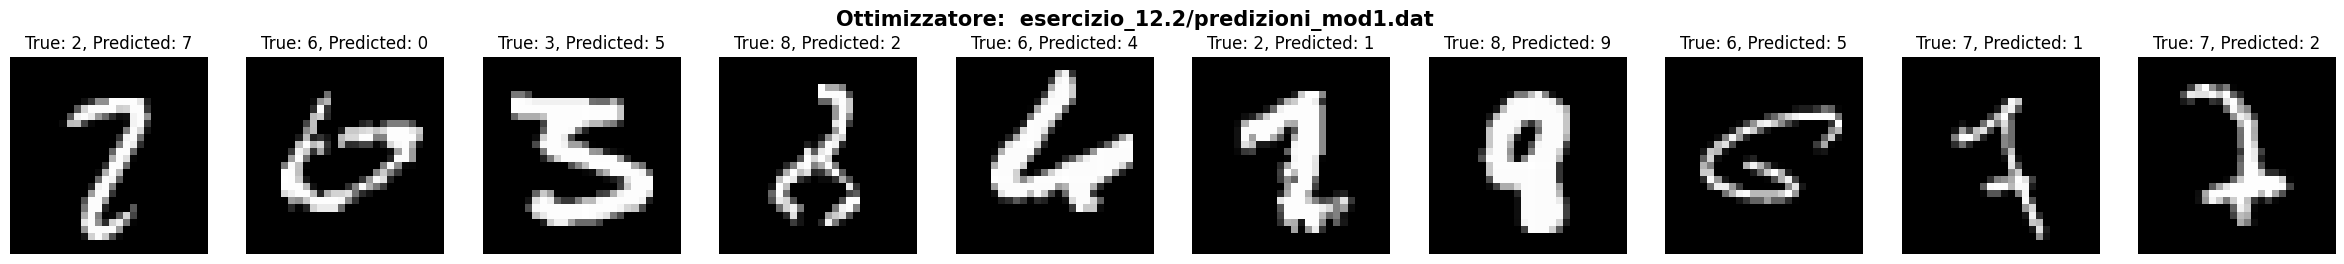

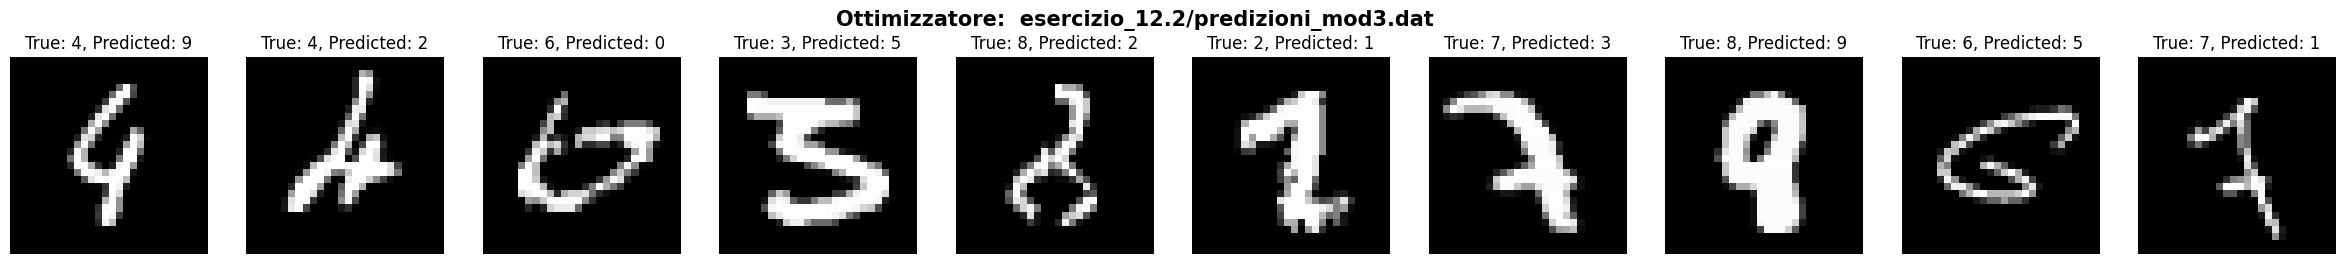

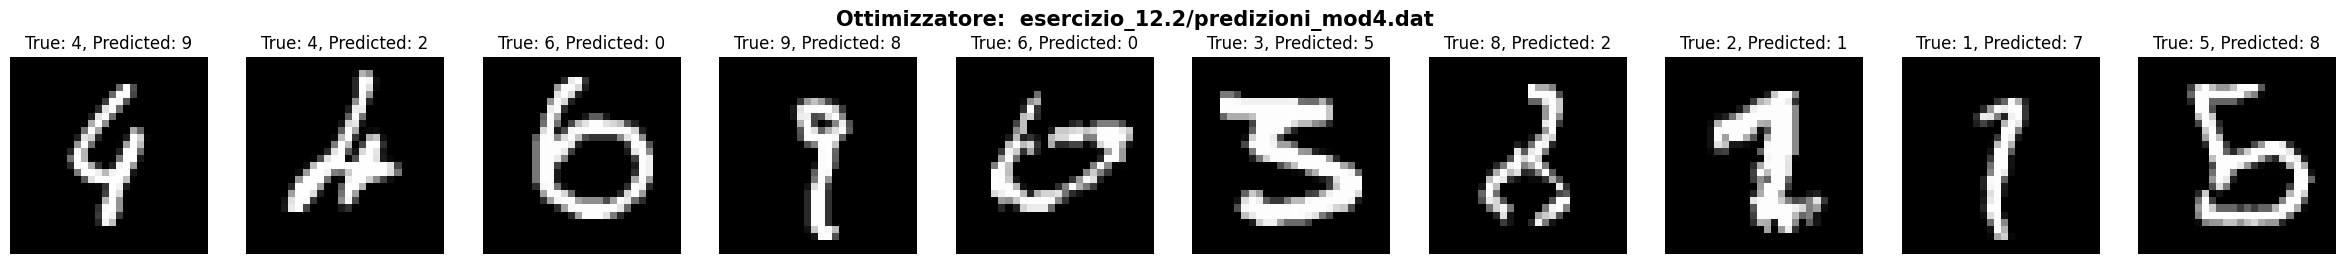

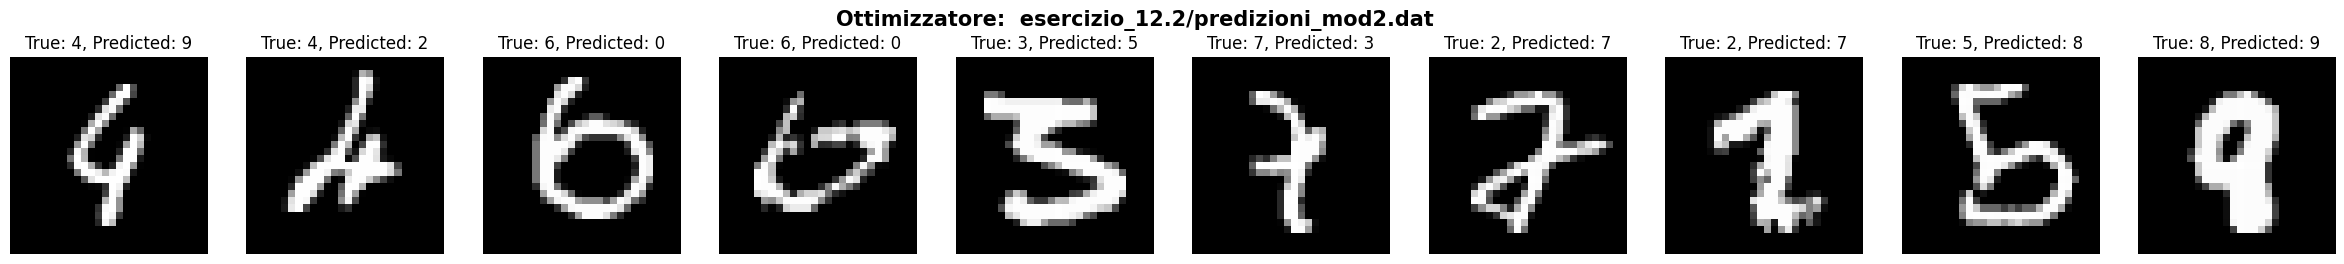

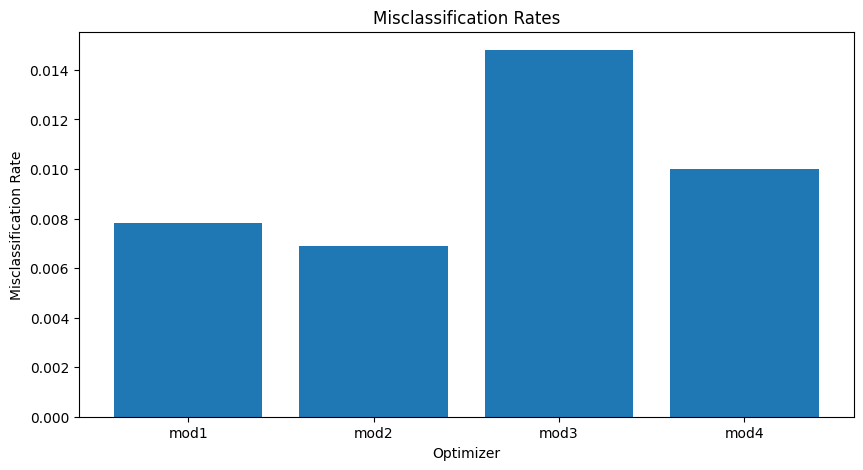

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Function to read data from a .dat file
def read_dat_file(filename):
    data = pd.read_csv(filename, sep='\s+', skiprows=0)
    return data

# List of filenames
filenames = ['esercizio_12.2/predizioni_mod1.dat', 'esercizio_12.2/predizioni_mod3.dat', 'esercizio_12.2/predizioni_mod4.dat', 'esercizio_12.2/predizioni_mod2.dat']

# Read data from each file and calculate misclassification rate
misclassification_rates = []
for filename in filenames:
    data = read_dat_file(filename)
    true_labels = data.iloc[:, 1].values
    predicted_labels = data.iloc[:, 2].values
    misclassified = sum(true_labels != predicted_labels)
    total = len(true_labels)
    misclassification_rate = misclassified / total
    misclassification_rates.append(misclassification_rate)

    # Get indices of misclassified digits
    misclassified_indices = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]
    misclassified_indices = misclassified_indices[:10]  # Select the first 10 misclassified digits

    # Plot the misclassified digits
    plt.figure(figsize=(30, 3))
    for i, index in enumerate(misclassified_indices, 1):
        plt.subplot(1, 10, i)
        plt.imshow(X_test[index+1].reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_labels[index]}, Predicted: {predicted_labels[index]}')
        plt.axis('off')
    plt.suptitle('Ottimizzatore:  ' + filename, fontsize = 15, fontweight = "bold")
    plt.show()

# Plot misclassification rates
plt.figure(figsize=(10, 5))
plt.bar(range(len(filenames)), misclassification_rates, tick_label=['mod1', 'mod2', 'mod3', 'mod4'])
plt.title('Misclassification Rates')
plt.xlabel('Optimizer')
plt.ylabel('Misclassification Rate')
plt.show()



In quest'ultimo grafico si osserva il rapporto tra il numero di predizioni errate sui dati di validazione e il numero totale di dati di validazione. Questo rapporto rappresenta l'errore di validazione finale, che è calcolato come (1 - accuracy) sui dati di validazione alla fine del training. In altre parole, mostra la percentuale di dati di validazione che il modello ha classificato in modo errato dopo 80 epoche di addestramento. Nei grafici precedenti, questo punto corrisponde precisamente al punto $N_{epoch}$, permettendo così di confrontare direttamente le prestazioni dei diversi modelli al termine del processo di training.

Come si nota, in questo caso i modelli hanno prestazioni simili; quella peggiore è data dal modello 3, caratterizzato da avere pochi parametri. Il migliore sembra essere il modello con complessità computazionale più elevata. Confrontando il modello 4 con il primo si vede un peggioramento dato, come visto prima, dall'overfitting.

Infine si può osservare che tutti questi errori di classificazione, ottenuti con la CNN, ridultano essere ben inferiori rispetto a quelli calcolati con la DNN, confermando dunque l'affermazione fatta precedente.

### Exercise 12.3

Use the `gimp` application to create 10 pictures of your "handwritten" digits, import them in your jupyter-notebook and try to see if your CNN is able to recognize your handwritten digits.

Per il riconoscimento delle cifre scritte da me, ho utilizzato i modelli migliori:
- per la DNN il modello sgd,
- per la CNN il modello 3,

Come si può osservare, le predizioni di entrambe le reti sono perfette.

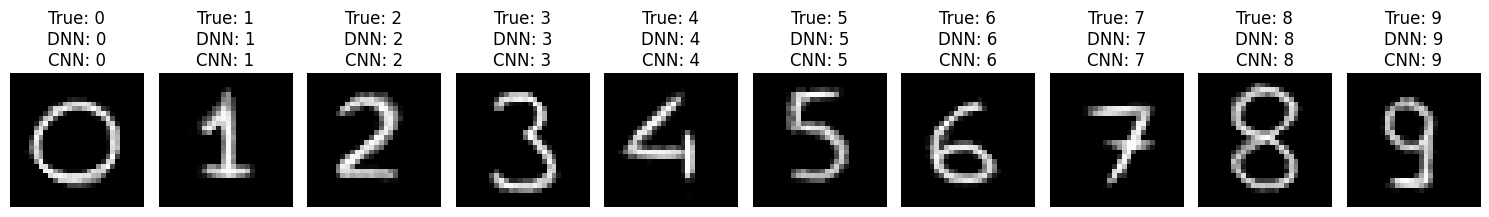

In [112]:
import os
import logging
import warnings
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Disabilita i warning e i messaggi di logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

# Disabilita le barre di caricamento
tf.autograph.set_verbosity(0)

# Carica i modelli CNN e DNN
model_DNN = load_model('esercizio_12.1/sgd.h5')
model_CNN = load_model('esercizio_12.2/mod4.h5')

# Numero di immagini
num_images = 10

# Crea una figura per visualizzare tutte le immagini e le previsioni
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i in range(num_images):
    img_path = 'esercizio_12.3/' + '{}.png'.format(i)
    img = Image.open(img_path).convert('L')  # Carica l'immagine in scala di grigi
    
    # Ridimensiona l'immagine alle dimensioni attese dal modello CNN (28x28)
    img_resized = img.resize((28, 28))
    
    # Converti l'immagine in un array numpy e normalizza i valori dei pixel
    img_array = np.array(img_resized) / 255.0
    
    # Aggiungi una dimensione di batch all'input (la CNN si aspetta un batch di immagini)
    img_input = np.expand_dims(img_array, axis=-1)
    img_input = np.expand_dims(img_input, axis=0)
    
    # Esegui la previsione con il modello DNN
    pred_DNN = model_DNN.predict(img_array.reshape(1, 784), verbose=0)
    
    # Esegui la previsione con il modello CNN
    pred_CNN = model_CNN.predict(img_input, verbose=0)
    
    # Visualizza l'immagine e le previsioni
    axes[i].imshow(img_array, cmap='gray')
    axes[i].set_title("True: {}\nDNN: {}\nCNN: {}".format(i, np.argmax(pred_DNN), np.argmax(pred_CNN)))
    axes[i].axis('off')

plt.tight_layout()
plt.show()
